In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2


In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
import argparse


%matplotlib inline


In [3]:
input_path = "/home/bryan/src/LLM-from-scratch/data/isoflops_curves.json"

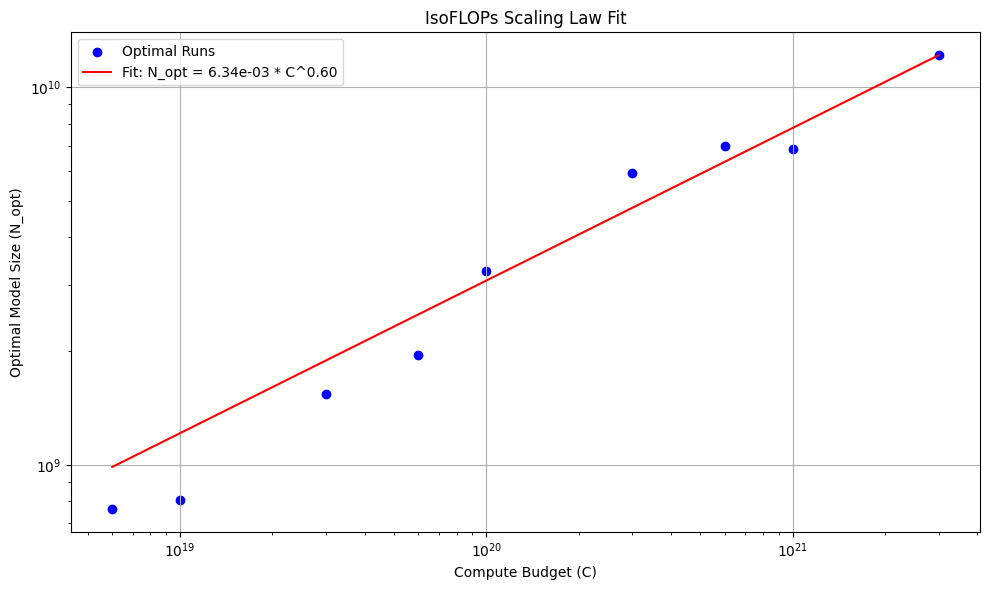

In [28]:
# Load the JSON data
with open(input_path, 'r') as f:
    data = json.load(f)

# Group by compute_budget and find the run with the lowest final loss for each budget
best_runs = defaultdict(lambda: {"final_loss": float("inf")})
for run in data:
    C = run["compute_budget"]
    if run["final_loss"] < best_runs[C]["final_loss"]:
        best_runs[C] = run

def get_data_size(compute_budget, parameters):
    return compute_budget / (6 * parameters)

# Extract optimal points
compute_budgets = []
optimal_params = []
optimal_data = []
for C, run in sorted(best_runs.items()):
    compute_budgets.append(C)
    optimal_params.append(run["parameters"])
    optimal_data.append(get_data_size(C, run["parameters"]))

compute_budgets = np.array(compute_budgets)
optimal_params = np.array(optimal_params)
optimal_data = np.array(optimal_data)

def fit_power_law(xvalues, yvalues):
    # Define the power law function
    def power_law(x, a, b):
        return a * x ** b

    # Fit the curve
    params_opt, _ = curve_fit(power_law, xvalues, yvalues)
    
    def fit_power_law(x):
        return power_law(x, *params_opt)
    return fit_power_law

params_power_law = fit_power_law(compute_budgets, optimal_params)
data_power_law = fit_power_law(compute_budgets, optimal_data)

def plot_IsoFLOPs(xvalues, yvalues, power_law, N_opt = "N_opt", ylabel = "Optimal Model Size (N_opt)"):
    # Generate fit line
    x_fit = np.linspace(min(xvalues), max(xvalues), 100)
    y_fit = power_law(x_fit)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(xvalues, yvalues, label='Optimal Runs', color='blue')
    plt.plot(x_fit, y_fit, label=f'Fit: {N_opt} = {params_opt[0]:.2e} * C^{params_opt[1]:.2f}', color='red')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Compute Budget (C)')
    plt.ylabel(ylabel)
    plt.title('IsoFLOPs Scaling Law Fit')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_IsoFLOPs(compute_budgets, optimal_params, params_power_law)

In [31]:
# optimal model size for budget of 10^23 FLOPS
print(f"compute budget: 10^23 FLOPS, optimal model size: {params_power_law(10**23):.2e}")
print(f"compute budget: 10^24 FLOPS, optimal model size: {params_power_law(10**24):.2e}")

compute budget: 10^23 FLOPS, optimal model size: 5.00e+10
compute budget: 10^24 FLOPS, optimal model size: 1.27e+11


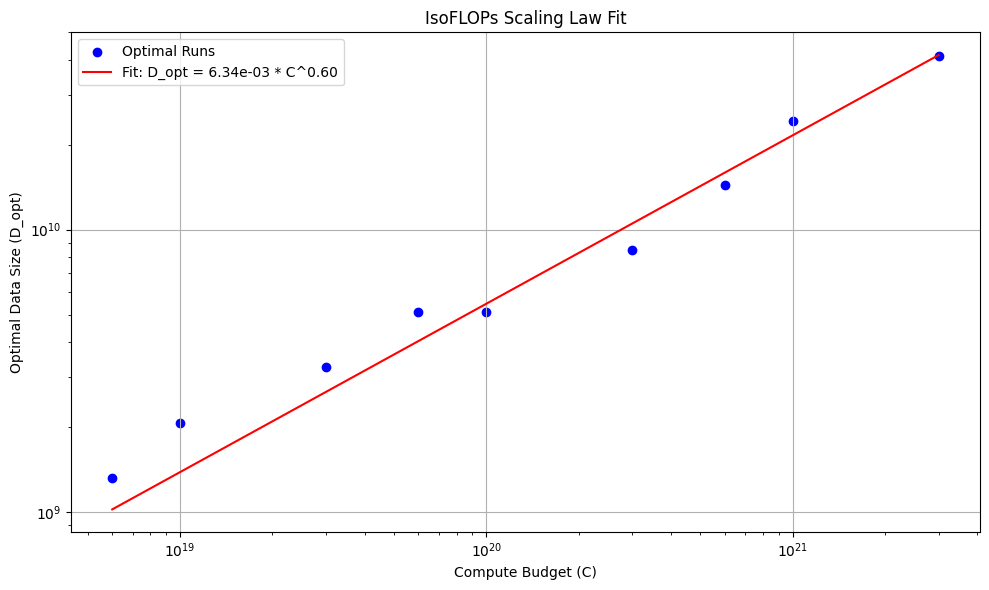

In [32]:
plot_IsoFLOPs(compute_budgets, optimal_data, data_power_law, "D_opt", "Optimal Data Size (D_opt)")

In [34]:
# optimal model size for budget of 10^23 FLOPS
print(f"compute budget: 10^23 FLOPS, optimal data size: {data_power_law(10**23):.2e} tokens")
print(f"compute budget: 10^24 FLOPS, optimal data size: {data_power_law(10**24):.2e} tokens")

compute budget: 10^23 FLOPS, optimal data size: 3.37e+11 tokens
compute budget: 10^24 FLOPS, optimal data size: 1.33e+12 tokens
